# System level

### Optimisation

This code presents the system-level analysis for the optimization problem. This involved the combination of the light and cost subsytems. The objective of this analysis is to find optimal positions to iluminate a room with lamps while accounting for a limited budget. 

During the system- level analysis different weighting for the light subsytem were analysed. The most effective solution resulted with a weight of 0.2. In order to reduce the computational cost of this example, only this case will be represented.

In [7]:
import time
import numpy as np
import numpy.ma as ma
import operator as op
import matplotlib.pyplot as plt
from scipy.optimize import minimize, BFGS, LinearConstraint, NonlinearConstraint

The following code imports the model parameter class, which includes the parameter for the light and cost subsystem. 

In [8]:
class MP:
    """
    Enum to hold some of the Model Parameters
    """

    """ 
    Global Parameters
    """

    # Discretisation step
    DXY = 0.01

    # Room geometry
    ROOM_LENGTH = 4
    ROOM_WIDTH = 3
    ROOM_HEIGHT = 2.3
    F_PLUG_POSITION = [2.3, 0.05]
    S_PLUG_POSITION = [3.95, 2]


    # Number of lamps
    N_LAMPS = 3

    # Parameters
    LAMP_EFFICIENCY = 0.8
    LAMP_RADII = [0.1, 0.2, 0.1]

    POWER_SCALING_FACTOR = 1
    LAMP_POW = [50, 120, 50]
    LAMP_POW = np.array(LAMP_POW) * POWER_SCALING_FACTOR

    # Albedo
    ALBEDO = 0.5
    BOUNCES = 3

    # Plot parameters
    N_LEVELS = 20

    """
    Light Quality Subsystem
    """

    # Initial lamp location guess (design variables: [x1, y1, x2, y2, x3, y3])
    INITIAL_GUESS_LAMP_LOCS = np.array([0.68978269, 0.98767149, 1.78447148, 2.79305784, 3.66072114, 2.4])

    # Linear Constraint Matrix
    CONSTRAINT_MAT = [[1, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]]

    # Lamp 1: Bed: Bound Constraints (x1, y1)
    G1 = [LAMP_RADII[0], 2.3 - LAMP_RADII[0]]
    G2 = [LAMP_RADII[0], 1.5 - LAMP_RADII[0]]

    # Lamp 2: Floor: Bound Constraints (x2, y2)
    G3 = [0.4 + LAMP_RADII[1], 2.3 - LAMP_RADII[1]]
    G4 = [0.9 + LAMP_RADII[1], 3 - LAMP_RADII[1]]

    # Lamp 3: Desk: Bound Constraints (x3, y3)
    G5 = [2.3 + LAMP_RADII[2], 4 - LAMP_RADII[2]]
    G6 = [1.1 + LAMP_RADII[2], 3 - LAMP_RADII[2]]

    CONSTRAINTS = [G1, G2, G3, G4, G5, G6]

    # Linear Constraint Bounds
    LOWER_BOUND = [constraint[0] for constraint in CONSTRAINTS]
    UPPER_BOUND = [constraint[1] for constraint in CONSTRAINTS]

    """
    Cost Subsystem
    """

    # Cost
    CABLE_COST = 2
    WORK_COST = 40
    ENERGY_COST = 0.12
    AVG_HOURS_PER_YEAR = float(2500 / 1000)
    INVESTMENT_FACTOR = 3
    # Bea's add
    # Initial characteristics for lamps
    INITIAL_SOLUTION = np.array([0.68978269, 0.98767149, 1.78447148, 2.79305784, 3.66072114, 2.22234, 0.2])

    # Efficiency, in a range from 0 to 1
    G7 = [0.2, 1]

    CONSTRAINT_MAT_EXT = [[1, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1]]

    # Add all constrains to limit all variables to 0

    CONSTRAINTS_EXT = [G1, G2, G3, G4, G5, G6, G7]

    # Linear Constraint Bounds
    LOWER_BOUND_EXT = [constraint[0] for constraint in CONSTRAINTS_EXT]
    UPPER_BOUND_EXT = [constraint[1] for constraint in CONSTRAINTS_EXT]

    """
    System Level

    """

    # Weight of different subsystems
    WEIGHT_LIGHT = 0.5
    WEIGHT_COST = 1 - WEIGHT_LIGHT

"""
FUNCTIONAL CONSTRAINTS
"""

def functional_constraint(variables):
    c_cable_tot = 0
    total_power = sum(MP.LAMP_POW)

    for i in range(3):
        c_cable_tot += (abs(variables[2 * i]) + abs(variables[2 * i + 1])) + 1.6
        c_cable_tot = c_cable_tot * MP.CABLE_COST

    lamp_efficiency = variables[6]
    c_operation = (total_power / lamp_efficiency) * MP.AVG_HOURS_PER_YEAR * MP.ENERGY_COST
    c_lamp = (lamp_efficiency / 0.2)
    c_tot_lamp_cost = MP.N_LAMPS * c_lamp
    c_work = np.log(MP.N_LAMPS) * MP.WORK_COST
    c_initial = (c_cable_tot + c_tot_lamp_cost + c_work)

    return c_initial - MP.INVESTMENT_FACTOR * c_operation

class Room:
    """
    The Room class contains the space in which the lighting optimisation will take place
    """

    def __init__(self, length, width):

        self.x = np.arange(0, length, MP.DXY)
        self.y = np.arange(0, width, MP.DXY)
        self.xx, self.yy = np.meshgrid(self.x, self.y, sparse=True)


Once the parameters are imported the intensisity distribution and cost functions are run. 

In [9]:
def get_intensity_distr(lamp_locs, refl=False):
    """
    Calculates the intensity distribution within a room with n number of light sources
    """

    room = Room(MP.ROOM_LENGTH, MP.ROOM_WIDTH)

    # No reflections
    if not refl:

        for i in range(MP.N_LAMPS):
            # Multiply by discretisation step to be in metres
            distance_to_lamp_n = ((room.xx - lamp_locs[2 * i]) ** 2 + (room.yy - lamp_locs[2 * i + 1]) ** 2)

            # Take out the value that are less than a radius away from the light source
            distance_to_lamp_n_filtered = ma.masked_less(np.sqrt(distance_to_lamp_n), MP.LAMP_RADII[i])

            if i == 0:
                # Initialise the light intensity array
                light_intensity = np.zeros_like(distance_to_lamp_n_filtered)

            # Find light intensity distribution
            light_intensity_n = ((MP.LAMP_EFFICIENCY * MP.LAMP_POW[i]) /
                                 (4 * np.pi)) / (distance_to_lamp_n_filtered * MP.DXY)

            light_intensity += light_intensity_n

        minimum = np.amin(light_intensity)
        minimum_coordinates = np.unravel_index(np.argmin(light_intensity), light_intensity.shape)

        return light_intensity, minimum, minimum_coordinates

    # With reflections
    elif refl:

        initialised = False

        # The first loop takes care of wall reflections
        for i in range(- MP.BOUNCES // 2, MP.BOUNCES // 2 + 1):
            # The second loop takes care of the three different lamps
            for j in range(MP.N_LAMPS):

                x_jk = 0.5 * (1 + (-1) ** i) * lamp_locs[2 * j] + \
                       0.5 * (1 - (-1) ** i) * (MP.ROOM_LENGTH - lamp_locs[2 * j])
                y_jk = 0.5 * (1 + (-1) ** i) * lamp_locs[2 * j + 1] + \
                       0.5 * (1 - (-1) ** i) * (MP.ROOM_WIDTH - lamp_locs[2 * j + 1])

                distance_to_lamp_n = ((room.xx - (x_jk - MP.ROOM_LENGTH * i)) ** 2 +
                                      (room.yy - (y_jk - MP.ROOM_WIDTH * i)) ** 2)

                # Take out the value that are less than a radius away from the light source
                distance_to_lamp_n_filtered = ma.masked_less(np.sqrt(distance_to_lamp_n), MP.LAMP_RADII[j])

                # Initialise the light intensity array
                if not initialised:
                    light_intensity = np.zeros_like(distance_to_lamp_n_filtered)
                    initialised = True

                # Find light intensity distribution
                light_intensity_n = ((MP.ALBEDO ** (abs(2 * i))) * (MP.LAMP_EFFICIENCY * MP.LAMP_POW[j]) /
                                     (4 * np.pi)) / (distance_to_lamp_n_filtered * MP.DXY)

                # Increment light intensity array
                light_intensity += light_intensity_n

        minimum = np.amin(light_intensity)
        minimum_coordinates = np.unravel_index(np.argmin(light_intensity), light_intensity.shape)

        return light_intensity, minimum, minimum_coordinates


In [12]:
def cost_obj_fun(variables):
    """
    Cost objective function. Vars is [x1, y1, x2, y2, x3, y3, e, i]
    Where c is equal for the three lamps and is equal to the the characteristics of lamp composed by price and efficiency
    """
    #Total cable cost is initialised
    c_cable_tot = 0

    # The power is fixed, so the total power is a sum of the power of all the lamps
    total_power = sum(MP.LAMP_POW)

    '''
    There are 7 variables in total
    In a range of 3 - which equals for iterations,  i = 0,1 and 2 will refer to each of the lamps. 
    The code will consider which considers i and i+1 for x, y  
    '''
    #Start the loop to calculate cable length
    for i in range(3):
        #Calcilate total length, including 1.6 m for the height of the lamps in the room.
        c_cable_tot += (abs(variables[2 * i]) + abs(variables[2 * i + 1])) + 1.6
        #Calculate the total price
        c_cable_tot = c_cable_tot * MP.CABLE_COST

    lamp_efficiency = variables[6]
    # Calculate the operation cost in terms of the efficiency
    c_operation = (total_power/lamp_efficiency) * MP.AVG_HOURS_PER_YEAR * MP.ENERGY_COST

    #Calculate the lamp cost in terms of the efficiency
    c_lamp = (lamp_efficiency/0.2)

    # Calculate total lamp cost
    c_tot_lamp_cost = MP.N_LAMPS * c_lamp

    # Calculate work cost
    c_work = np.log(MP.N_LAMPS) * MP.WORK_COST

    #Caltulate the initial cost
    c_initial = (c_cable_tot + c_tot_lamp_cost + c_work)

    #Caltulate total cost
    c_tot = c_initial + c_operation

    return c_tot




The trust constr algorithm is utlised for the system-level optimization. In this case, as stated in the introduction of this jupyter notebook, the solution will only be calculated for a weight of 0.2 for the light subsystem. 

In [13]:
class TrustConstrModel:
    """
    Two-dimensional model of light distribution in a plane with n number of light sources
    """

    def __init__(self, weight_light = False):

        # To keep track of the iterations
        self.counter = 0

        # Parameters
        self.name = 'Trust-Constr'
        self.refl = True
        self.save_fig = True
        self.save_log = False
        self.constrained = True

        if not weight_light:
            self.weight_light = MP.WEIGHT_LIGHT
        else:
            self.weight_light = weight_light

        if self.save_log:
            self.data = []

        if self.constrained:
            self.constraints = (LinearConstraint(MP.CONSTRAINT_MAT_EXT, MP.LOWER_BOUND_EXT, MP.UPPER_BOUND_EXT),
                                NonlinearConstraint(functional_constraint, -np.inf, 0, jac='cs', hess=BFGS()))
        else:
            self.constraints = ()

        print("Welcome! You are using a trust-constr optimiser.")
        print("Reflections: ", self.refl)
        print("Constraints: ", self.constrained)

        time.sleep(1)
        # Objective function. We want to maximise this

        self.result = minimize(self.obj_fun, MP.INITIAL_SOLUTION, method='trust-constr', jac='3-point',
                            constraints=self.constraints, hess=BFGS(exception_strategy='damp_update'))

        # What is the result of the optimisation?
        print(self.result)

    def obj_fun(self, vars):
        """
        Objective function to be minimised. This maximises the ratio between the minimum light intensity and total cost.
        """

        # Calculate current intensity distribution
        light_intensity, minimum, minimum_coordinates = get_intensity_distr(vars, refl=self.refl)

        # Calculate total cost of given distribution
        total_cost = cost_obj_fun(vars)

        # Since we want to maximise with a minimisation approach we need to minimise the negative function value
        print("Iteration: ", self.counter, " Variables: ", [round(var, 2) for var in vars], " Minimum: ", round(minimum, 2), " Cost: ",
              round(total_cost, 2))
        self.counter += 1

        return (1 - self.weight_light) * total_cost - self.weight_light * minimum


if __name__ == '__main__':

    filename = 'pareto.txt'
    file = open(filename, 'w')

    #weight_light_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #For the purpose of this Jupyter notebook we will only calculate for weight light range = 0.2 
    weight_light_range = [0.2]

    for weight in weight_light_range:
        model = TrustConstrModel(weight)
        file.write('Light Weight: ' + str(weight) + ' Optimum: ' + str(model.result.x))
        file.write('\n')
        print("Now solving for weight: ", weight)

    file.close()

Welcome! You are using a trust-constr optimiser.
Reflections:  True
Constraints:  True


Iteration:  0  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  1  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  2  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  3  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  4  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  5  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84


Iteration:  6  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  7  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  8  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  9  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84


Iteration:  10  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  11  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  12  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.84
Iteration:  13  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.85
Iteration:  14  Variables:  [0.69, 0.99, 1.78, 2.79, 3.66, 2.22, 0.2]  Minimum:  596.95  Cost:  442.83


Iteration:  15  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  16  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  17  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  18  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  19  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  20  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27


Iteration:  21  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  22  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  23  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  24  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  25  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  26  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  27  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27
Iteration:  28  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.28
Iteration:  29  Variables:  [0.74, 0.93, 1.7, 2.62, 3.56, 2.19, 0.28]  Minimum:  602.59  Cost:  345.27


Iteration:  30  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  31  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  32  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  33  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  34  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  35  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  36  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45


Iteration:  37  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  38  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  39  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  40  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  41  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.86  Cost:  318.45
Iteration:  42  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  43  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.45
Iteration:  44  Variables:  [0.74, 0.93, 1.7, 2.61, 3.55, 2.19, 0.32]  Minimum:  602.85  Cost:  318.44
Iteration:  45  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8


Iteration:  46  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  47  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  48  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  49  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  50  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  51  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  52  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  53  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  54  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  55  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  6

Iteration:  56  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  57  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  58  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.81
Iteration:  59  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.36]  Minimum:  603.05  Cost:  294.8
Iteration:  60  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  61  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  62  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  63  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  64  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  65  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minim

Iteration:  66  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  67  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  68  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  69  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  70  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  71  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  72  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  73  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.36
Iteration:  74  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.41]  Minimum:  603.25  Cost:  277.35
Iteration:  75  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Mi

Iteration:  77  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  78  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  79  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  80  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  81  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  82  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  83  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  84  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  85  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  86  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Mi

Iteration:  88  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  89  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.19, 0.44]  Minimum:  603.45  Cost:  264.76
Iteration:  90  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  91  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.65  Cost:  255.23
Iteration:  92  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  93  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  94  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  95  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.65  Cost:  255.23
Iteration:  96  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  97  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Mi

Iteration:  98  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.65  Cost:  255.23
Iteration:  99  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.65  Cost:  255.23
Iteration:  100  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  101  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  102  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.65  Cost:  255.23
Iteration:  103  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  104  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.47]  Minimum:  603.66  Cost:  255.23
Iteration:  105  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  106  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  107  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5

Iteration:  108  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  109  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  110  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  111  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  112  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  113  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  114  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  115  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  116  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  117  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Mi

Iteration:  118  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  119  Variables:  [0.74, 0.92, 1.7, 2.61, 3.55, 2.18, 0.5]  Minimum:  603.86  Cost:  247.74
Iteration:  120  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  121  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  122  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  123  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  124  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  125  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  126  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  127  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Mi

Iteration:  128  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  129  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  130  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  131  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  132  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  133  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.68
Iteration:  134  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.53]  Minimum:  604.06  Cost:  241.67
Iteration:  135  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  136  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  137  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Mi

Iteration:  138  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  139  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  140  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  141  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  142  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  143  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  144  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  145  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  146  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  147  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Mi

Iteration:  148  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  149  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.55]  Minimum:  604.27  Cost:  236.64
Iteration:  150  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  151  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  152  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  153  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  154  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  155  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  156  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  157  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Mi

Iteration:  158  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  159  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  160  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  161  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  162  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  163  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  164  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.18, 0.57]  Minimum:  604.47  Cost:  232.38
Iteration:  165  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  166  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  167  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Mi

Iteration:  168  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  169  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  170  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  171  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  172  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  173  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  174  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  175  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  176  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  177  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Mi

Iteration:  178  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  179  Variables:  [0.74, 0.92, 1.7, 2.6, 3.55, 2.17, 0.59]  Minimum:  604.68  Cost:  228.72
Iteration:  180  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  181  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  182  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  183  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  184  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  185  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  186  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  187  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0

Iteration:  188  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  189  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  190  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  191  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  192  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  193  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  194  Variables:  [0.74, 0.92, 1.71, 2.6, 3.55, 2.17, 0.61]  Minimum:  604.89  Cost:  225.53
Iteration:  195  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  196  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  197  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0

Iteration:  198  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  199  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  200  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  201  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  202  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  203  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  204  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  205  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  206  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  207  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  M

Iteration:  208  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.72
Iteration:  209  Variables:  [0.74, 0.91, 1.71, 2.6, 3.55, 2.17, 0.63]  Minimum:  605.1  Cost:  222.71
Iteration:  210  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  211  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  212  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  213  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  214  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  215  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  216  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  217  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55,

Iteration:  218  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.31  Cost:  220.21
Iteration:  219  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  220  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  221  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  222  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.31  Cost:  220.21
Iteration:  223  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  224  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.64]  Minimum:  605.32  Cost:  220.21
Iteration:  225  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  226  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  227  Variables:  [0.74, 0.91, 1.71, 2.59, 3

Iteration:  228  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  229  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  230  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  231  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  232  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  233  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  234  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  235  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  236  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  237  Variables:  [0.74, 0.91, 1.71, 2.59, 3

Iteration:  238  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  239  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.66]  Minimum:  605.53  Cost:  217.97
Iteration:  240  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  241  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  242  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  243  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  244  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  245  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  246  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  247  Variables:  [0.74, 0.91, 1.71, 2.59, 3

Iteration:  248  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  249  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  250  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  251  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  252  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  253  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  254  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.17, 0.68]  Minimum:  605.75  Cost:  215.94
Iteration:  255  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  256  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  257  Variables:  [0.74, 0.91, 1.71, 2.59, 3.5

Iteration:  258  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  259  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  260  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  261  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  262  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  263  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  264  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  265  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  266  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  267  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16

Iteration:  268  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  269  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.69]  Minimum:  605.97  Cost:  214.1
Iteration:  270  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  271  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  272  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  273  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  274  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  275  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  276  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  277  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16

Iteration:  278  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  279  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  280  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  281  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  282  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  283  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.42
Iteration:  284  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.7]  Minimum:  606.19  Cost:  212.41
Iteration:  285  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  286  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  287  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.

Iteration:  288  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  289  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  290  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  291  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  292  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  293  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  294  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  295  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  296  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  297  Variables:  [0.74, 0.91, 1.71, 2.59, 3

Iteration:  298  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  299  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.72]  Minimum:  606.42  Cost:  210.87
Iteration:  300  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  301  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  302  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  303  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  304  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  305  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  306  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  307  Variables:  [0.74, 0.91, 1.71, 2.59, 3

Iteration:  308  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  309  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  310  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  311  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  312  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  313  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  314  Variables:  [0.74, 0.91, 1.71, 2.59, 3.55, 2.16, 0.73]  Minimum:  606.65  Cost:  209.44
Iteration:  315  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  316  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  317  Variables:  [0.74, 0.91, 1.71, 2.58, 3

Iteration:  318  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  319  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  320  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  321  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  322  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  323  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  324  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  325  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  326  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  327  Variables:  [0.74, 0.91, 1.71, 2.58, 3

Iteration:  328  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  329  Variables:  [0.74, 0.91, 1.71, 2.58, 3.55, 2.16, 0.74]  Minimum:  606.88  Cost:  208.12
Iteration:  330  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  331  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  332  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  333  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  334  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  335  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  336  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  337  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.1

Iteration:  338  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  339  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  340  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  341  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  342  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  343  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  344  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.75]  Minimum:  607.12  Cost:  206.89
Iteration:  345  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  346  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  347  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15,

Iteration:  348  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  349  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  350  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  351  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  352  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  353  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  354  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  355  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  356  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  357  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15,

Iteration:  358  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  359  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.77]  Minimum:  607.36  Cost:  205.75
Iteration:  360  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  361  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  362  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  363  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  364  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  365  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  366  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  367  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15,

Iteration:  368  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  369  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  370  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  371  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  372  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  373  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  374  Variables:  [0.74, 0.9, 1.71, 2.58, 3.55, 2.15, 0.78]  Minimum:  607.59  Cost:  204.67
Iteration:  375  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  376  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  377  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15,

Iteration:  378  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  379  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  380  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  381  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  382  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  383  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  384  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  385  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  386  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  387  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15,

Iteration:  388  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  389  Variables:  [0.74, 0.9, 1.72, 2.58, 3.55, 2.15, 0.79]  Minimum:  607.82  Cost:  203.67
Iteration:  390  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  391  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  392  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  393  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  394  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  395  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  396  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  397  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  

Iteration:  399  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  400  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  401  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  402  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  403  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  404  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.15, 0.8]  Minimum:  608.05  Cost:  202.72
Iteration:  405  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  406  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  407  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  408  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]

Iteration:  409  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  410  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  411  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  412  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  413  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  414  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  415  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  416  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  417  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  418  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14,

Iteration:  419  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.81]  Minimum:  608.29  Cost:  201.83
Iteration:  420  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  421  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  422  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  423  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  424  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  425  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  426  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  427  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  428  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14,

Iteration:  429  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  430  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  431  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  432  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  433  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  434  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.82]  Minimum:  608.52  Cost:  200.99
Iteration:  435  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  436  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  437  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19


Iteration:  438  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  439  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  440  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  441  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  442  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  443  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  444  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  445  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  446  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  447  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14,

Iteration:  448  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  449  Variables:  [0.74, 0.9, 1.72, 2.57, 3.55, 2.14, 0.83]  Minimum:  608.76  Cost:  200.19
Iteration:  450  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  451  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  452  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  453  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  454  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  455  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  456  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  457  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14,

Iteration:  458  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  459  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  460  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  461  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  462  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  463  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  464  Variables:  [0.73, 0.9, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  608.99  Cost:  199.44
Iteration:  465  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  466  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  467  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.

Iteration:  468  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  469  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  470  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  471  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  472  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  473  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  474  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  475  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  476  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  477  Variables:  [0.73, 0.89, 1.72, 2.57, 3

Iteration:  478  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  479  Variables:  [0.73, 0.89, 1.72, 2.57, 3.55, 2.14, 0.84]  Minimum:  609.23  Cost:  198.72
Iteration:  480  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  481  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  482  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  483  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  484  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  485  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04


Iteration:  486  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  487  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  488  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  489  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  490  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  491  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  492  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  493  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04
Iteration:  494  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.85]  Minimum:  609.47  Cost:  198.04


Iteration:  495  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  496  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  497  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  498  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  499  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  500  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  501  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  502  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  503  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  504  Variables:  [0.73, 0.89, 1.72, 2.56, 3

Iteration:  505  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  506  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  507  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  508  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  509  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.86]  Minimum:  609.71  Cost:  197.39
Iteration:  510  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  511  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  512  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  513  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  514  Variables:  [0.73, 0.89, 1.72, 2.56, 3

Iteration:  515  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  516  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  517  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  518  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  519  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  520  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  521  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  522  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.94  Cost:  196.77
Iteration:  523  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.87]  Minimum:  609.95  Cost:  196.77
Iteration:  524  Variables:  [0.73, 0.89, 1.72, 2.56, 3

Iteration:  525  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  526  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  527  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  528  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  529  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  530  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  531  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  532  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  533  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  534  Variables:  [0.73, 0.89, 1.72, 2.56, 3

Iteration:  535  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  536  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  537  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  538  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  539  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.88]  Minimum:  610.19  Cost:  196.18
Iteration:  540  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  541  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62


Iteration:  542  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  543  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  544  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  545  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  546  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  547  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  548  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  549  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  550  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  551  Variables:  [0.73, 0.89, 1.72, 2.56, 3

Iteration:  552  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  553  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  554  Variables:  [0.73, 0.89, 1.72, 2.56, 3.55, 2.13, 0.89]  Minimum:  610.43  Cost:  195.62
Iteration:  555  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  556  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  557  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  558  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08


Iteration:  559  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  560  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  561  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  562  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  563  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  564  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  565  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  566  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  567  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  568  Variables:  [0.73, 0.89, 1.73, 2.55, 3

Iteration:  569  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.89]  Minimum:  610.67  Cost:  195.08
Iteration:  570  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  571  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  572  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  573  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  574  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  575  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  576  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  577  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  578  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.1

Iteration:  579  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  580  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  581  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  582  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  583  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  584  Variables:  [0.73, 0.89, 1.73, 2.55, 3.55, 2.12, 0.9]  Minimum:  610.91  Cost:  194.56
Iteration:  585  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  586  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  587  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  588  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2

Iteration:  589  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  590  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  591  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  592  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  593  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  594  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  595  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  596  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  597  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  598  Variables:  [0.73, 0.88, 1.73, 2.55, 3

Iteration:  599  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.16  Cost:  194.07
Iteration:  600  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  601  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  602  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  603  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  604  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  605  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  606  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  607  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  608  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]

Iteration:  609  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  610  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  611  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  612  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  613  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  614  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.12, 0.91]  Minimum:  611.4  Cost:  193.6
Iteration:  615  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  616  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  617  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  618  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0

Iteration:  619  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  620  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  621  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  622  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  623  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  624  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  625  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  626  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  627  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  628  Variables:  [0.73, 0.88, 1.73, 2.55, 3

Iteration:  629  Variables:  [0.73, 0.88, 1.73, 2.55, 3.55, 2.11, 0.92]  Minimum:  611.65  Cost:  193.15
Iteration:  630  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  631  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  632  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  633  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  634  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  635  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  636  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  637  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  638  Variables:  [0.73, 0.88, 1.73, 2.55, 3

Iteration:  639  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  640  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  641  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  642  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  643  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  644  Variables:  [0.73, 0.88, 1.73, 2.55, 3.56, 2.11, 0.93]  Minimum:  611.89  Cost:  192.71
Iteration:  645  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  646  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  647  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  648  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56

Iteration:  649  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  650  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  651  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  652  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  653  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  654  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  655  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  656  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  657  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  658  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11

Iteration:  659  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.93]  Minimum:  612.14  Cost:  192.3
Iteration:  660  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  661  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  662  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  663  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  664  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  665  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  666  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  667  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  668  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11

Iteration:  669  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  670  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  671  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  672  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  673  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  674  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.94]  Minimum:  612.39  Cost:  191.9
Iteration:  675  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  676  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  677  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  678  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2

Iteration:  679  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  680  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.63  Cost:  191.52
Iteration:  681  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  682  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  683  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.63  Cost:  191.52
Iteration:  684  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  685  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  686  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  687  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.63  Cost:  191.52
Iteration:  688  Variables:  [0.73, 0.88, 1.73, 2.54, 3

Iteration:  689  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.11, 0.95]  Minimum:  612.64  Cost:  191.52
Iteration:  690  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  691  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  692  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  693  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  694  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  695  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  696  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  697  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  698  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1

Iteration:  699  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  700  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  701  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  702  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  703  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  704  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.95]  Minimum:  612.88  Cost:  191.15
Iteration:  705  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  706  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  707  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  708  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1,

Iteration:  709  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  710  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  711  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  712  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  713  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  714  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  715  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  716  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  717  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  718  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1,

Iteration:  719  Variables:  [0.73, 0.88, 1.73, 2.54, 3.56, 2.1, 0.96]  Minimum:  613.13  Cost:  190.81
Iteration:  720  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  721  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  722  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  723  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  724  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  725  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  726  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  727  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48


Iteration:  728  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  729  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  730  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  731  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  732  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  733  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.48
Iteration:  734  Variables:  [0.73, 0.87, 1.73, 2.53, 3.56, 2.1, 0.96]  Minimum:  613.38  Cost:  190.47
Iteration:  735  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  736  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  737  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1,

Iteration:  738  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  739  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  740  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  741  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  742  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  743  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  744  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  745  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  746  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  747  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1,

Iteration:  748  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  749  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.63  Cost:  190.16
Iteration:  750  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  751  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  752  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  753  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  754  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  755  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  756  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  757  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1,

Iteration:  758  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  759  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  760  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  761  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  762  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  763  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  764  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.1, 0.97]  Minimum:  613.88  Cost:  189.87
Iteration:  765  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  766  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  767  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.

Iteration:  768  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  769  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  770  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  771  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  772  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  773  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  774  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  775  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  776  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  777  Variables:  [0.73, 0.87, 1.74, 2.53, 3

Iteration:  778  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  779  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.13  Cost:  189.59
Iteration:  780  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  781  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  782  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  783  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  784  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  785  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  786  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34


Iteration:  787  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  788  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  789  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  790  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  791  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.38  Cost:  189.34
Iteration:  792  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  793  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  794  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.98]  Minimum:  614.37  Cost:  189.34
Iteration:  795  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11


Iteration:  796  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  797  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  798  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  799  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  800  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  801  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  802  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  803  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  804  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  805  Variables:  [0.73, 0.87, 1.74, 2.53, 3

Iteration:  806  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  807  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  808  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  809  Variables:  [0.73, 0.87, 1.74, 2.53, 3.56, 2.09, 0.99]  Minimum:  614.62  Cost:  189.11
Iteration:  810  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  811  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  812  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  813  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  814  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91


Iteration:  815  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  816  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  817  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  818  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  819  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  820  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  821  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  822  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  823  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  614.86  Cost:  188.91
Iteration:  824  Variables:  [0.73, 0.87, 1.74, 2.52, 3

Iteration:  825  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  826  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  827  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  828  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  829  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  830  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  831  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  832  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  833  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  834  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09

Iteration:  835  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  836  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  837  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  838  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.76
Iteration:  839  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.09, 0.99]  Minimum:  615.1  Cost:  188.75
Iteration:  840  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  841  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  842  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  843  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  844  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 

Iteration:  845  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  846  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  847  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  848  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  849  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  850  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  851  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  852  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  853  Variables:  [0.73, 0.87, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.32  Cost:  188.74
Iteration:  854  Variables:  [0.73, 0.87, 1.74, 2.52, 3

Iteration:  855  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  856  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  857  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  858  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  859  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  860  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  861  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  862  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  863  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  864  Variables:  [0.73, 0.86, 1.74, 2.52, 3

Iteration:  865  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  866  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  867  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  868  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  869  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.58  Cost:  188.72
Iteration:  870  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  871  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  872  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  873  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  874  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56,

Iteration:  875  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  876  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  877  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  878  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  879  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  880  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  881  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  882  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  883  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  615.84  Cost:  188.7
Iteration:  884  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08

Iteration:  885  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  886  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  887  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  888  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  889  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  890  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  891  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  892  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68


Iteration:  893  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  894  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  895  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  896  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  897  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  898  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68
Iteration:  899  Variables:  [0.73, 0.86, 1.74, 2.52, 3.56, 2.08, 0.99]  Minimum:  616.1  Cost:  188.68


Iteration:  900  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  901  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  902  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  903  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  904  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  905  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  906  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  907  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  908  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  909  Variables:  [0.73, 0.86, 1.74, 2.51, 3

Iteration:  910  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  911  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  912  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  913  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  914  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.08, 0.99]  Minimum:  616.37  Cost:  188.66
Iteration:  915  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  916  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  917  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  918  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  919  Variables:  [0.73, 0.86, 1.74, 2.51, 3

Iteration:  920  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.63  Cost:  188.64
Iteration:  921  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  922  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  923  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.63  Cost:  188.64
Iteration:  924  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.63  Cost:  188.64
Iteration:  925  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  926  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  927  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.63  Cost:  188.64
Iteration:  928  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64


Iteration:  929  Variables:  [0.73, 0.86, 1.74, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.64  Cost:  188.64
Iteration:  930  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  931  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  932  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  933  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  934  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  935  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  936  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62


Iteration:  937  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  938  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  939  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  940  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  941  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  942  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  943  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62
Iteration:  944  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  616.9  Cost:  188.62


Iteration:  945  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  946  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  947  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  948  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  949  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  950  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  951  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  952  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  953  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6


Iteration:  954  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  955  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  956  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  957  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  958  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  959  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.17  Cost:  188.6
Iteration:  960  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  961  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58


Iteration:  962  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  963  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  964  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  965  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  966  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  967  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  968  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  969  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  970  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58


Iteration:  971  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  972  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  973  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  974  Variables:  [0.73, 0.86, 1.75, 2.51, 3.56, 2.07, 0.99]  Minimum:  617.44  Cost:  188.58
Iteration:  975  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  976  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  977  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  978  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  979  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56


Iteration:  980  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  981  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  982  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  983  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  984  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  985  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  986  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  987  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration: 

 988  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.57
Iteration:  989  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.71  Cost:  188.56
Iteration:  990  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  991  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  992  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  993  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  994  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  995  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55


Iteration:  996  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  997  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  998  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  999  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  1000  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  1001  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  1002  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  1003  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55
Iteration:  1004  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  617.98  Cost:  188.55


Iteration:  1005  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1006  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1007  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1008  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1009  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1010  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1011  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1012  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1013  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1014  Variables:  [0.73, 0.85, 1.75, 2.5, 3

Iteration:  1015  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1016  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1017  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1018  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1019  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.26  Cost:  188.53
Iteration:  1020  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1021  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1022  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1023  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1024  Variables:  [0.73, 0.85, 1.75, 2.5, 3

Iteration:  1025  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1026  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1027  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1028  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1029  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1030  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1031  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1032  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1033  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.53  Cost:  188.51
Iteration:  1034  Variables:  [0.73, 0.85, 1.75, 2.5, 3

Iteration:  1035  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1036  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1037  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1038  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1039  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1040  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1041  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1042  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1043  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1044  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06

Iteration:  1045  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1046  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.81  Cost:  188.49
Iteration:  1047  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1048  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1049  Variables:  [0.73, 0.85, 1.75, 2.5, 3.56, 2.06, 0.99]  Minimum:  618.8  Cost:  188.49
Iteration:  1050  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1051  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1052  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1053  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47


Iteration:  1054  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1055  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1056  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1057  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1058  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1059  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1060  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1061  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1062  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47


Iteration:  1063  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1064  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.08  Cost:  188.47
Iteration:  1065  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1066  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1067  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1068  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1069  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1070  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1071  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45


Iteration:  1072  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1073  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.35  Cost:  188.45
Iteration:  1074  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1075  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1076  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1077  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.35  Cost:  188.45
Iteration:  1078  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1079  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.36  Cost:  188.45
Iteration:  1080  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.63  Cost:  188.43
Iteration:  1081  Variables:  [0.73, 0.85, 1.7

Iteration:  1082  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.63  Cost:  188.43
Iteration:  1083  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.63  Cost:  188.43
Iteration:  1084  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.63  Cost:  188.43
Iteration:  1085  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.63  Cost:  188.43
Iteration:  1086  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.63  Cost:  188.43
Iteration:  1087  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.63  Cost:  188.43
Iteration:  1088  Variables:  [0.73, 0.85, 1.75, 2.49, 3.56, 2.05, 0.99]  Minimum:  619.63  Cost:  188.43


KeyboardInterrupt: 

The following code plots the behaviour of both subsystems for different weigthings.

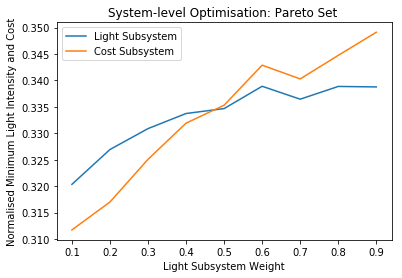

In [ ]:

%matplotlib inline

weight_light_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
light_values =  np.array([717.8, 732.55, 741.41, 747.8, 749.89, 759.34, 753.87, 759.27, 759.07])
cost_values = np.array([173.73, 176.67, 181.17, 184.98, 186.87, 191.09, 189.64, 192.12, 194.56])

light_values = light_values / np.linalg.norm(light_values)
cost_values = cost_values / np.linalg.norm(cost_values)

plot = plt.figure()
plt.plot(weight_light_range, light_values)
plt.plot(weight_light_range, cost_values)
plt.legend(['Light Subsystem', 'Cost Subsystem'])
plt.title('System-level Optimisation: Pareto Set ')
plt.xlabel('Light Subsystem Weight')
plt.ylabel('Normalised Minimum Light Intensity and Cost')
plt.savefig('../plots/' + 'ParetoSet.svg', format='svg', dpi=1200)
plt.show()